<img width="50" src="https://carbonplan-assets.s3.amazonaws.com/monogram/dark-small.png" style="margin-left:0px;margin-top:20px"/>

# Macroalgae data prep

_by Joe Hamman, October 7, 2021_

This notebook processes multiple data layers related to the modeling of macroalgae for the purpose
of carbon removal. The basic steps in this notebook are as follows:

1. load and normalize input datasets
2. build data pyramid for web map tool using `ndpyramid.pyramid_reproject`
3. merge data layers into a single multi-dimensional array
4. set storage encoding
5. write data to cloud object store in Zarr format


## imports and options


In [1]:
import xarray as xr
import fsspec
import pandas as pd
import numpy as np

import rioxarray  # noqa: F401
import datatree
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib import cm

from ndpyramid import pyramid_reproject
from carbonplan_data.metadata import get_cf_global_attrs
from carbonplan_data.utils import set_zarr_encoding
from carbonplan_styles.mpl import set_theme
from carbonplan.watermark import watermark
import zarr

from utils import compute_grid_area

# paths and versions
input_prefix = "gs://carbonplan-macroalgae/data/raw/tool"
output_prefix = "gs://carbonplan-macroalgae/data/processed/tool"
version = 0.17
write = False

# options for data processing
pixels_per_tile = 128
levels = 6
mask_threshold = 0.01

# options for diagnostic plots
plot_diagnostics = True
theme = set_theme()
cmap = cm.get_cmap("cool_light").copy()
cmap.set_bad("0.5")

In [2]:
watermark(
    packages="fsspec,matplotlib,numpy,pandas,xarray,rioxarray,datatree,ndpyramid,cartopy,zarr,carbonplan,carbonplan_data"
)

Last updated: 2022-03-16T15:49:28.756219+00:00

Python implementation: CPython
Python version       : 3.8.12
IPython version      : 7.10.2

fsspec         : 2022.2.0
matplotlib     : 3.4.3
numpy          : 1.20.3
pandas         : 1.3.4
xarray         : 2022.3.0
rioxarray      : 0.8.0
datatree       : 0.1.dev91+g54edbf7.d20220315
ndpyramid      : 0.0.post61
cartopy        : 0.20.1
zarr           : 2.11.2.dev2+dirty
carbonplan     : 0.5.0
carbonplan_data: 0.4.0

Compiler    : GCC 9.4.0
OS          : Linux
Release     : 5.4.144+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

Git hash: ab4fbcedc1f9fe30c4336b665853773841b3c07e



## helper functions


In [3]:
def load_data():
    ds = xr.Dataset()

    print("loading sensitive area masks")
    with fsspec.open(f"{input_prefix}/sensitive_area_maps_v2.nc", mode="rb") as f:
        ds_raw = xr.open_dataset(f).load()
        ds["sensitive_areas"] = (
            (ds_raw.shipping_lanes.isnull() * 1) + (ds_raw.marine_protected_areas.isnull() * 2)
        ).astype("float64")

    print("loading d2p")
    with fsspec.open(f"{input_prefix}/d2port.nc", mode="rb") as f:
        ds_raw = xr.open_dataset(f).load()
        ds["d2p"] = xr.DataArray(ds_raw["d2p"].values, dims=("latitude", "longitude"))

    print("loading nvar + harv")

    with fsspec.open(
        f"{input_prefix}/Preferred_species_f0_v2.nc",
        mode="rb",
    ) as f:
        ds_raw = xr.open_dataset(f).load()
        ds["species_preferred"] = xr.DataArray(
            ds_raw["index_H"].values, dims=("latitude", "longitude")
        )
        ds["harv_preferred"] = xr.DataArray(
            ds_raw["Harvest"].values, dims=("latitude", "longitude")
        )
        ds["nharv_preferred"] = xr.DataArray(
            ds_raw["nharv_H"].values, dims=("latitude", "longitude")
        )

    # hack to work around alignment issues
    print("loading elevation")
    with fsspec.open(f"{input_prefix}/gebco_cwm.nc", mode="rb") as f:
        ds["elevation"] = xr.DataArray(
            xr.open_dataset(f)["elevation"].values, dims=("latitude", "longitude")
        )

    print("loading d2sink")
    with fsspec.open(f"{input_prefix}/d2sink_fseq_maps_v3.nc", mode="rb") as f:
        ds_raw = xr.open_dataset(f).load()
        ds["d2sink"] = xr.DataArray(ds_raw["d2sink"].values, dims=("latitude", "longitude"))
        ds["fseq"] = xr.DataArray(ds_raw["fseq_100years"].values, dims=("latitude", "longitude"))
        ds["fseq_transport"] = xr.DataArray(
            ds_raw["fseq_100years_withtransport"].values, dims=("latitude", "longitude")
        )

    print("loading wave height")
    with fsspec.open(f"{input_prefix}/ecmwf_swh_2003_9km.nc", mode="rb") as f:
        with xr.open_dataset(f) as ds_temp:
            # TODO: replace with proper calculation (waiting on email from UCI)
            ds["wave_height"] = xr.DataArray(
                ds_temp["swh_mean"].mean("time").values, dims=("latitude", "longitude")
            )

    print("loading mask")
    with fsspec.open(f"{input_prefix}/mask_cbpm_2021_01_13.txt", mode="r") as f:
        df = pd.read_csv(f, sep=" ", header=None)
        ds["mask"] = xr.DataArray(df.values, dims=("latitude", "longitude"))
        ds["mask"] = ds["mask"].astype("float64")

    ds["longitude"] = ds["longitude"].where(ds["longitude"] < 180, ds["longitude"] - 360)

    ds["area"] = compute_grid_area(ds["mask"])

    return ds


def merge_layers(ds):
    da = ds.to_array(dim="variable").chunk(dict(x=pixels_per_tile, y=pixels_per_tile))
    merged_ds = da.to_dataset(name="all_variables")
    return merged_ds

## load data


In [4]:
ds = load_data()
display(ds)

loading sensitive area masks
loading d2p
loading nvar + harv
loading elevation
loading d2sink
loading wave height
loading mask


<xarray.Dataset>
Dimensions:            (latitude: 2160, longitude: 4320)
Coordinates:
  * latitude           (latitude) float64 89.96 89.88 89.79 ... -89.88 -89.96
  * longitude          (longitude) float64 -180.0 -179.9 -179.8 ... 179.9 180.0
Data variables:
    sensitive_areas    (latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    d2p                (latitude, longitude) float32 4.633 4.633 ... 2.801e+03
    species_preferred  (latitude, longitude) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    harv_preferred     (latitude, longitude) float32 nan nan nan ... nan nan nan
    nharv_preferred    (latitude, longitude) float32 nan nan nan ... nan nan nan
    elevation          (latitude, longitude) float32 -4.212e+03 ... 2.836e+03
    d2sink             (latitude, longitude) float32 nan nan nan ... nan nan nan
    fseq               (latitude, longitude) float32 nan nan nan ... nan nan nan
    fseq_transport     (latitude, longitude) float32 nan nan nan ... nan nan nan
    wave_height        (latitude, longitude) float32 nan nan nan ... nan nan nan
    mask               (latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    area               (latitude, longitude) float64 6.244 6.244 ... 6.244 6.244

In [5]:
points = {
    "pacific": {"longitude": -90, "latitude": 2},
    "north_sea": {"longitude": 0, "latitude": 58},
    "alaska": {"longitude": -165, "latitude": 55},
    "argentina": {"longitude": -66, "latitude": -46},
    "yellow_sea": {"longitude": 124.5, "latitude": 33.3},
}

locations = []

species = {
    0: "tropical red",
    1: "tropical brown",
    2: "temperate red",
    3: "temperate brown",
    4: "temperate brown",
}

for key, p in points.items():
    temp = ds.sel(**p, method="nearest")
    temp["depth"] = temp["elevation"] * -1
    s = temp.to_pandas().rename({"harv_preferred": "seaweed_dw", "nharv_preferred": "nharv"})
    s["species"] = species[s["species_preferred"]]
    locations.append(
        {
            "key": key,
            "point": list(p.values()),
            "values": s[
                [
                    "seaweed_dw",
                    "d2p",
                    "fseq_transport",
                    "d2sink",
                    "species",
                    "depth",
                    "nharv",
                    "wave_height",
                ]
            ].to_dict(),
        }
    )
#     break

In [6]:
locations

[{'key': 'pacific',
  'point': [-90, 2],
  'values': {'seaweed_dw': 7939.91552734375,
   'd2p': 192.85289001464844,
   'fseq_transport': 0.9930768013000488,
   'd2sink': 0.0,
   'species': 'tropical red',
   'depth': 2016.75,
   'nharv': 8.0,
   'wave_height': 1.4342491626739502}},
 {'key': 'north_sea',
  'point': [0, 58],
  'values': {'seaweed_dw': 1636.282470703125,
   'd2p': 29.229372024536133,
   'fseq_transport': 0.7799999713897705,
   'd2sink': 428.871826171875,
   'species': 'temperate brown',
   'depth': 131.5,
   'nharv': 2.0,
   'wave_height': 1.8970307111740112}},
 {'key': 'alaska',
  'point': [-165, 55],
  'values': {'seaweed_dw': 1316.7147216796875,
   'd2p': 99.7650146484375,
   'fseq_transport': 0.9700000286102295,
   'd2sink': 115.72320556640625,
   'species': 'temperate brown',
   'depth': 91.25,
   'nharv': 1.0,
   'wave_height': 1.9661271572113037}},
 {'key': 'argentina',
  'point': [-66, -46],
  'values': {'seaweed_dw': 2587.830322265625,
   'd2p': 103.0491561889648

## diagnostic plots of "raw" data


In [7]:
def plot_ds(ds, coarsen=10):
    for k, da in ds.items():
        plt.figure(figsize=(14, 6), dpi=100)

        if coarsen is not None:
            da = da.coarsen(longitude=coarsen, latitude=coarsen).mean()

        print(k)
        p = da.plot(
            robust=True,
            cmap=cmap,
            subplot_kws=dict(projection=ccrs.PlateCarree()),
            transform=ccrs.PlateCarree(),
            zorder=9,
        )
        plt.tight_layout()
        p.axes.set_global()
        p.axes.coastlines(color="#EBEBEC", zorder=11)
        p.axes.add_feature(cartopy.feature.LAND, facecolor="#1B1E23", zorder=10)

sensitive_areas
d2p
species_preferred
harv_preferred
nharv_preferred
elevation
d2sink
fseq
fseq_transport
wave_height
mask
area


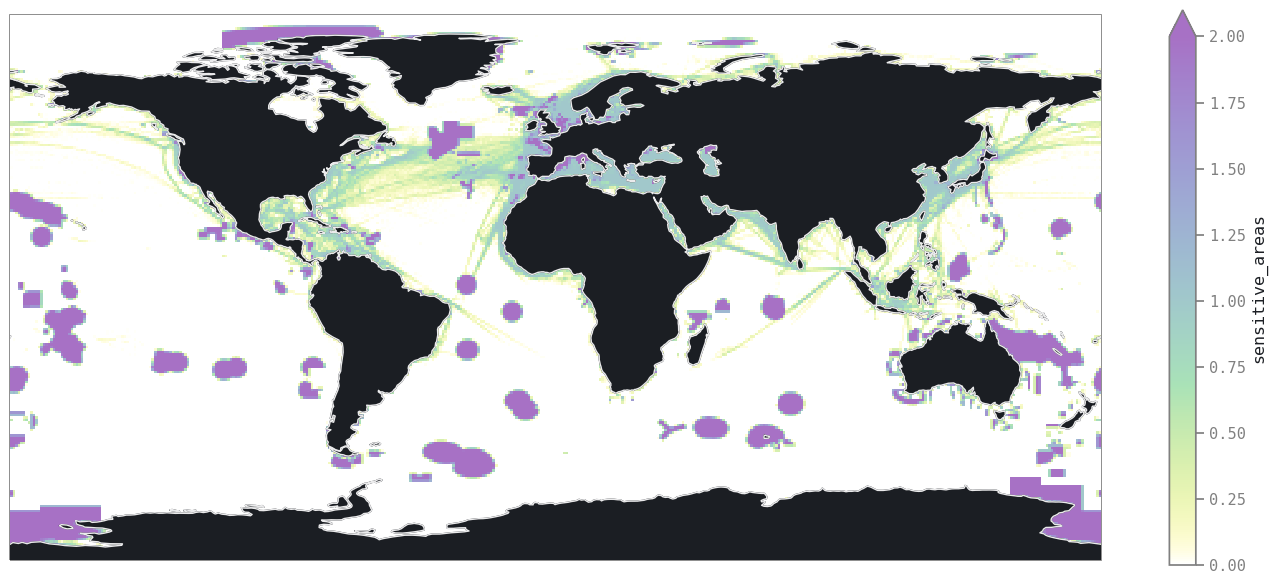

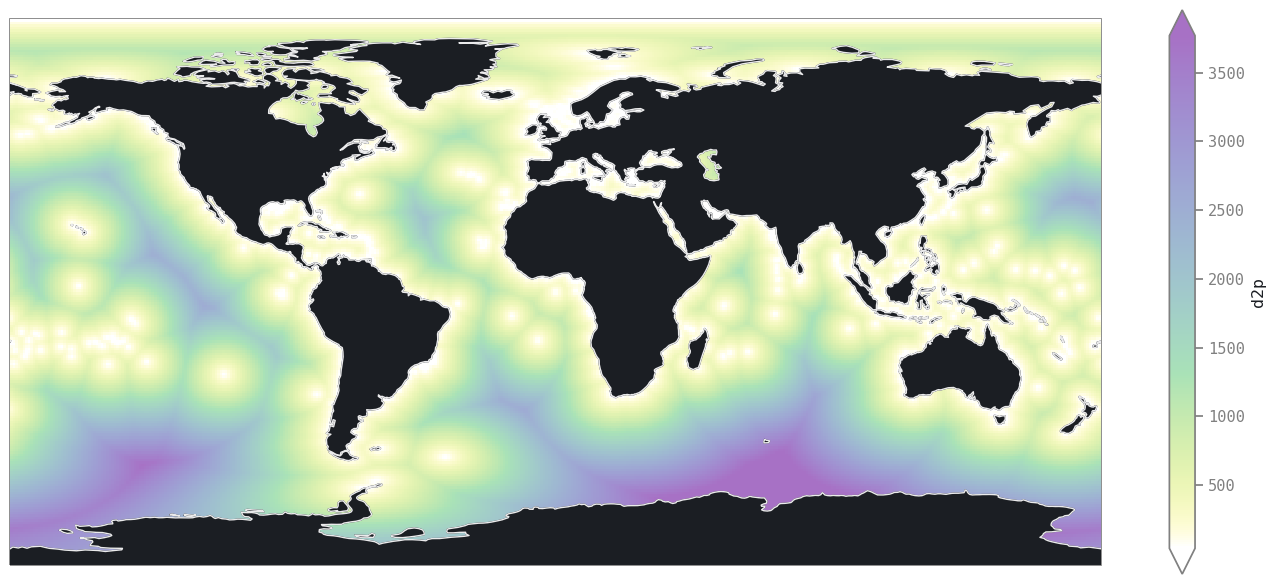

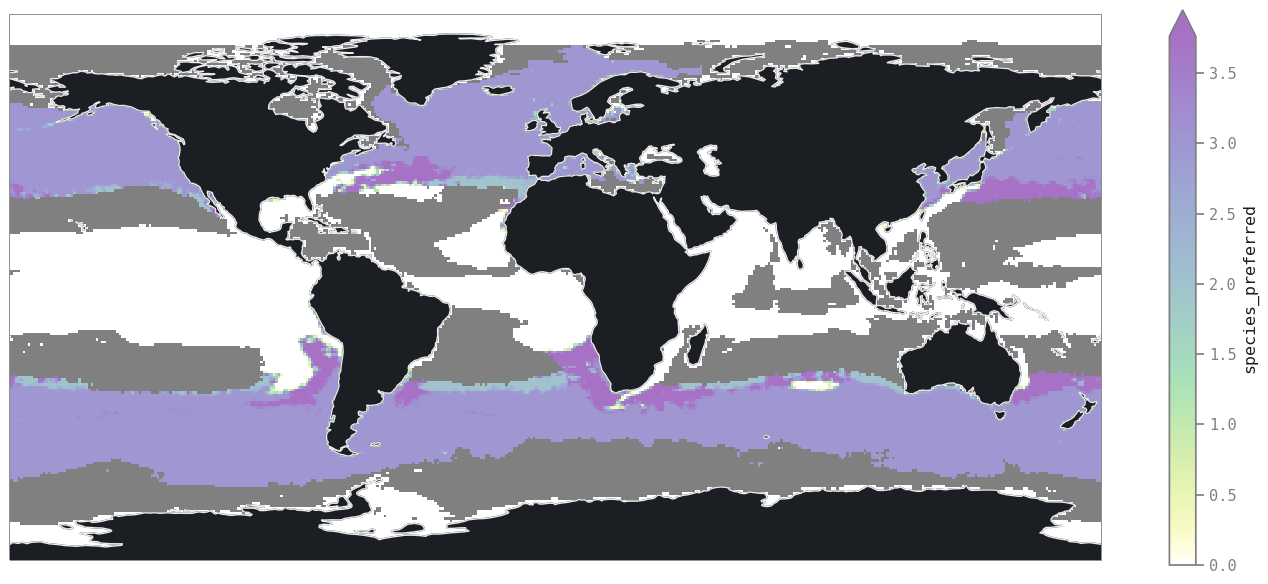

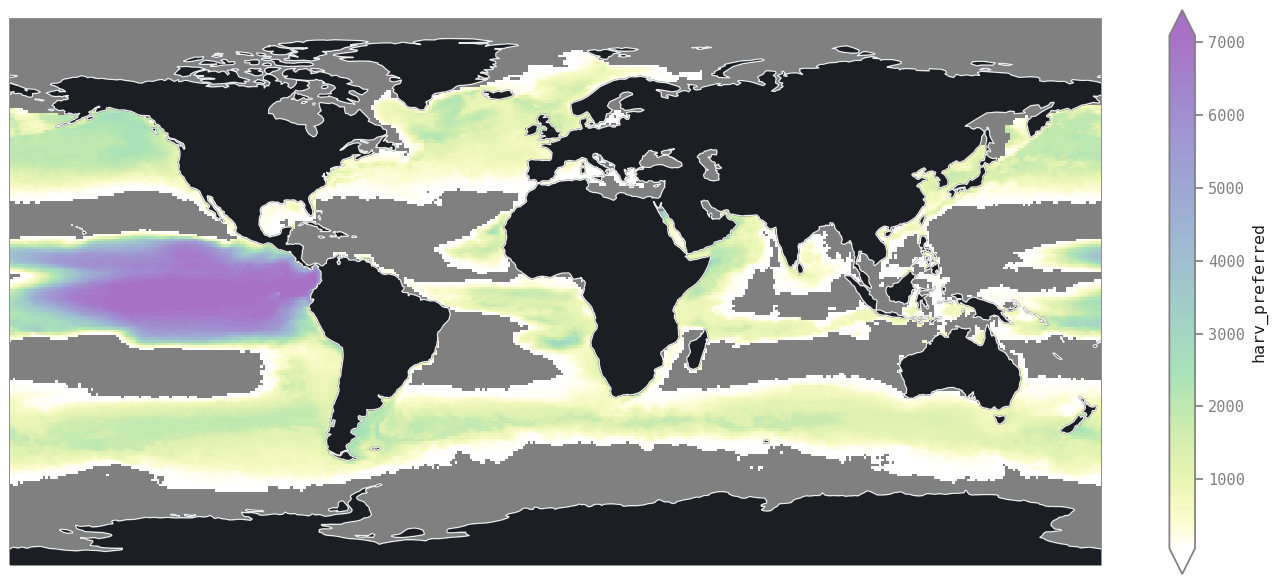

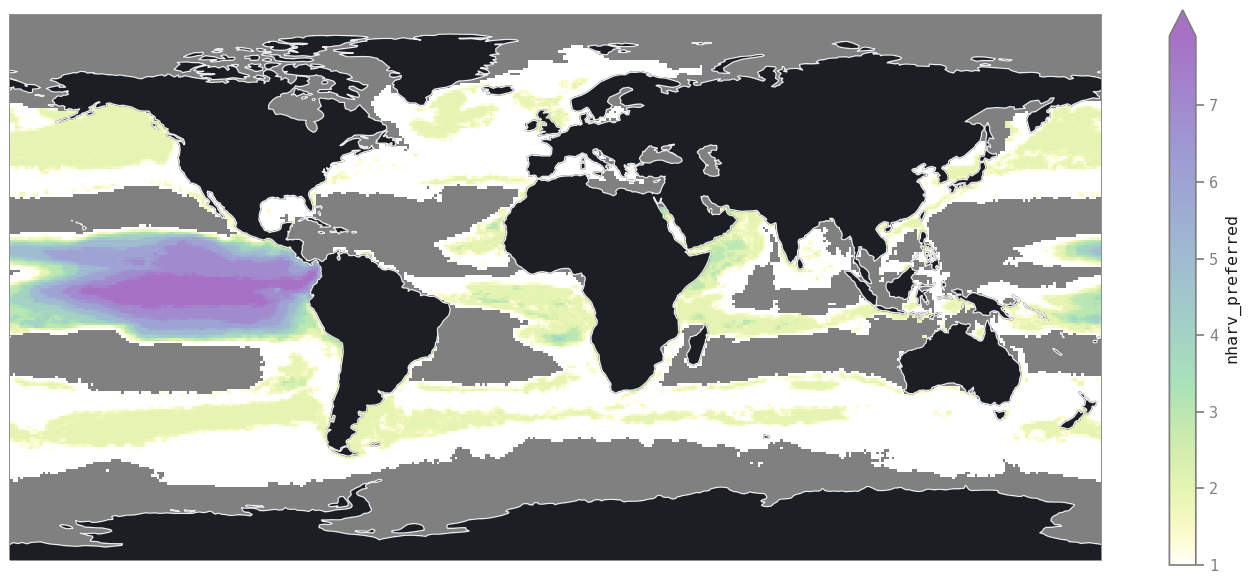

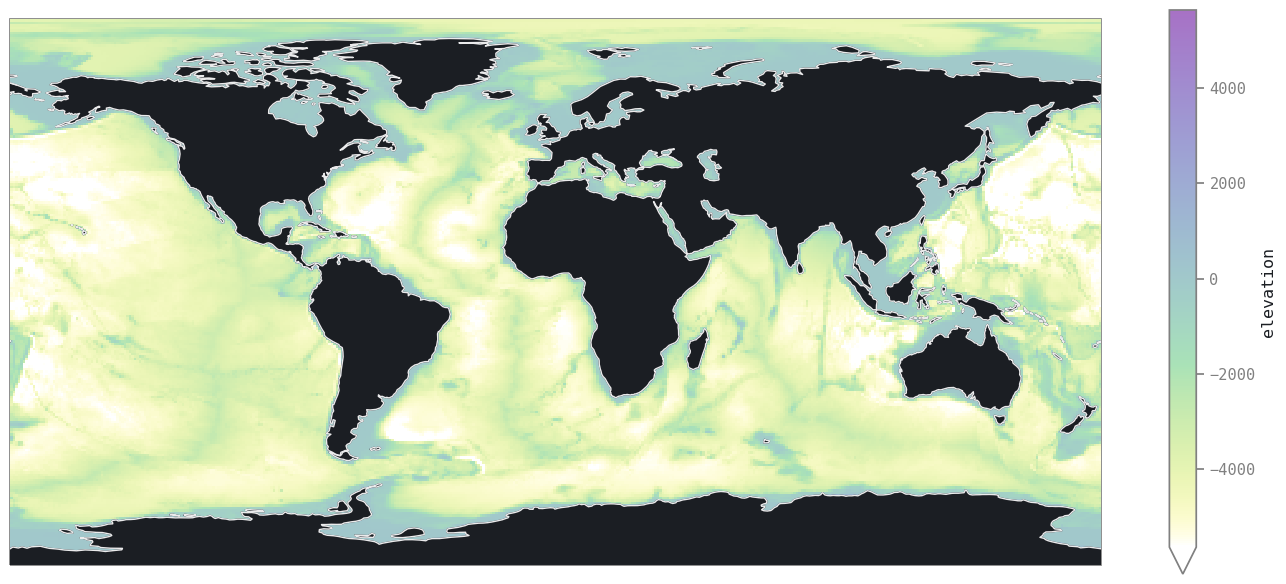

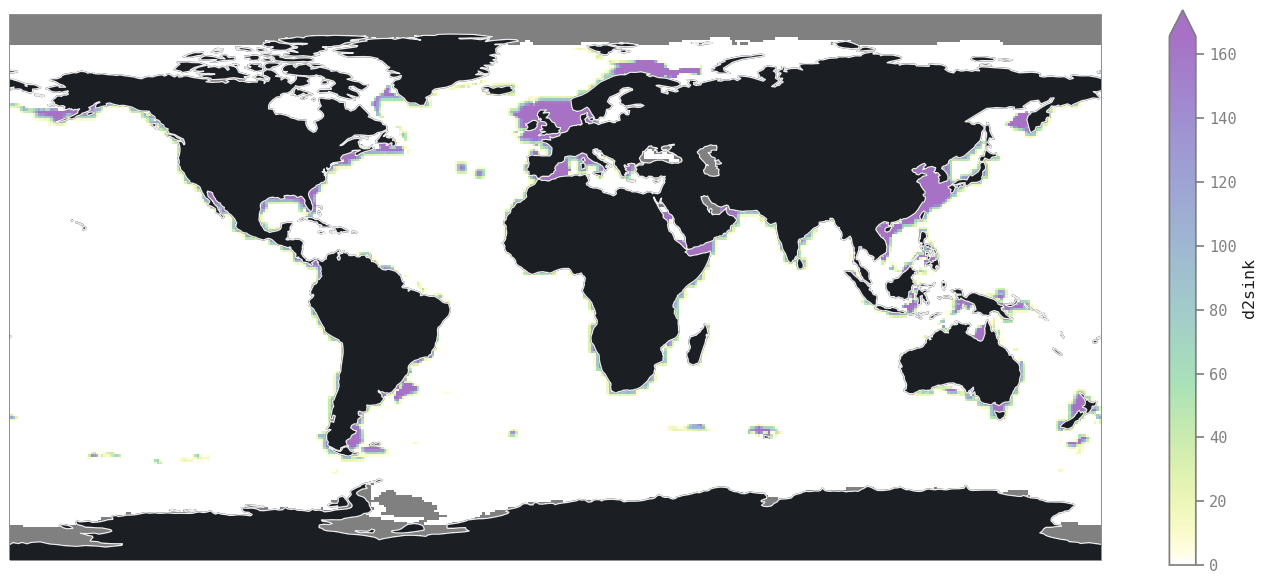

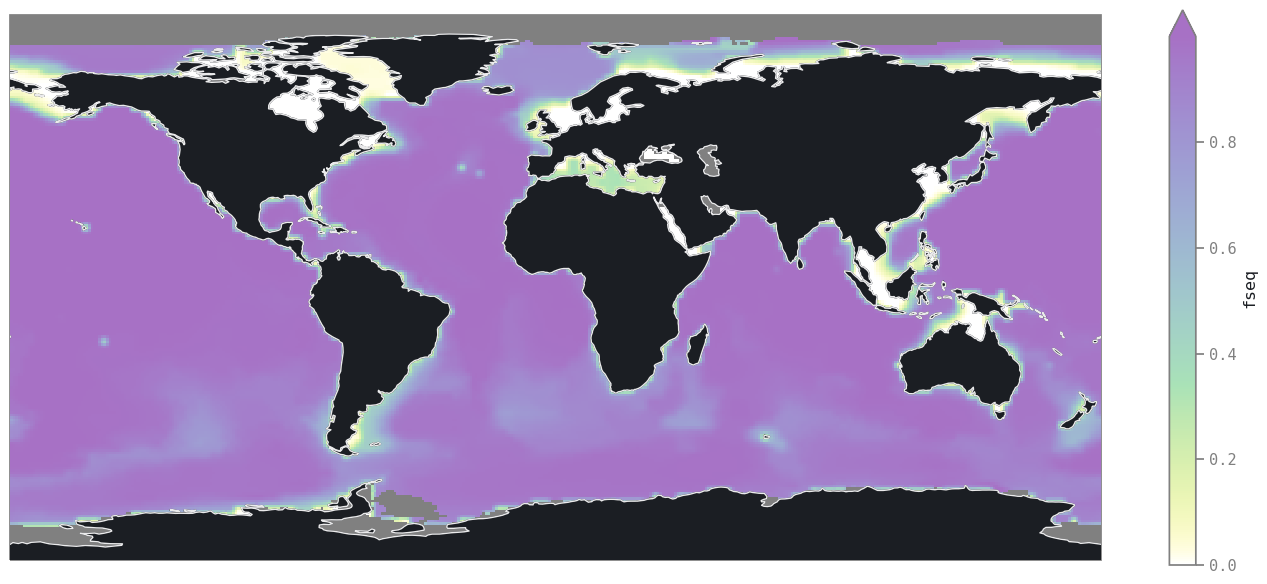

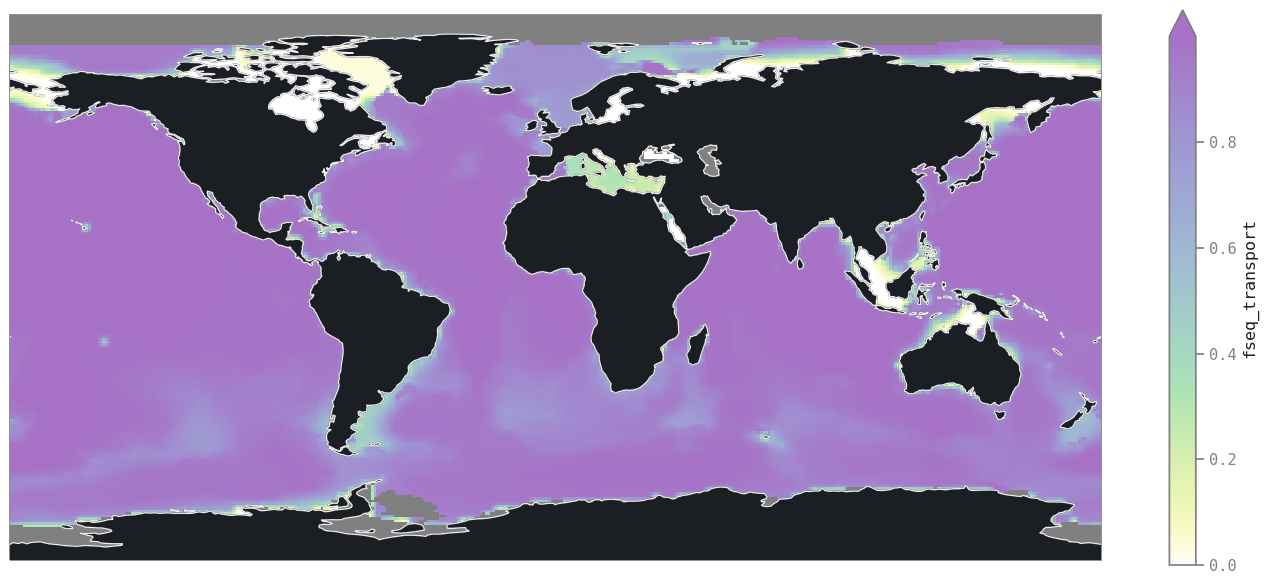

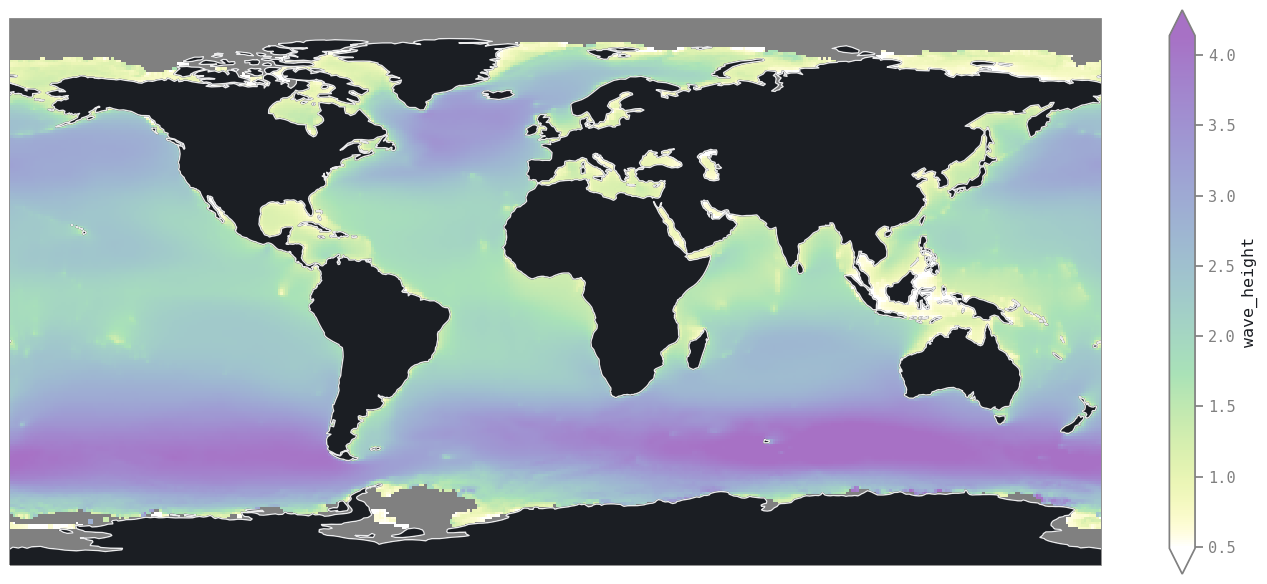

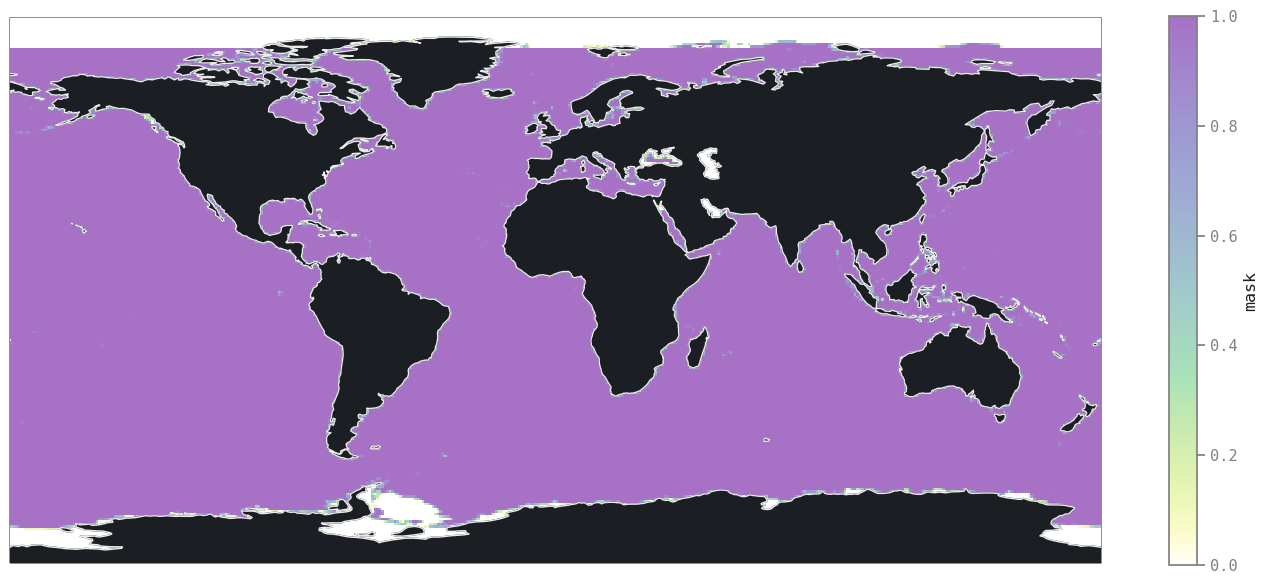

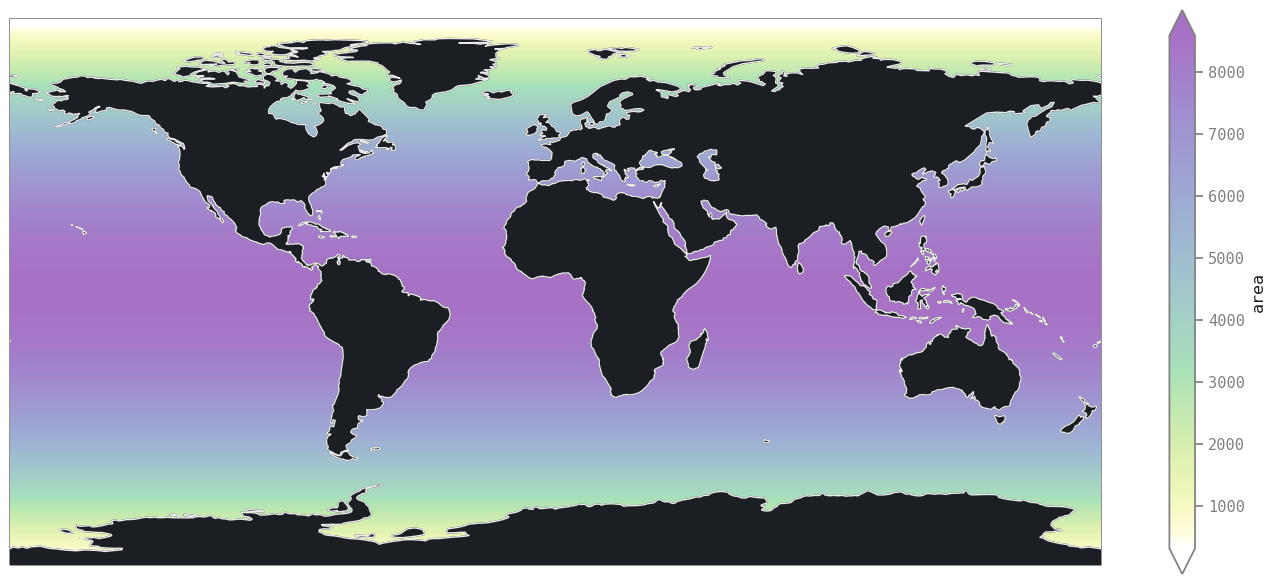

In [8]:
if plot_diagnostics:
    plot_ds(ds, coarsen=10)

## create the data pyramid

Here we create a multi-dimensional data pyramid. Data is masked based on a threshold set in the
options section above.


In [9]:
mode_vars = ["species_preferred", "nharv_preferred", "sensitive_areas"]

resampling = defaultdict(lambda: "average")

for v in mode_vars:
    resampling[v] = "mode"

In [10]:
# for the variables that use mode resampling, we set the fill value to -1
for v in mode_vars:
    ds[v] = ds[v].fillna(-1)

ds["species_preferred"] = ds["species_preferred"].where(ds["harv_preferred"] > 0)
ds["species_preferred"]

<xarray.DataArray 'species_preferred' (latitude: 2160, longitude: 4320)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 89.96 89.88 89.79 ... -89.79 -89.88 -89.96
  * longitude  (longitude) float64 -180.0 -179.9 -179.8 ... 179.8 179.9 180.0

In [11]:
ds = ds.rio.write_crs("EPSG:4326")
pyramid = pyramid_reproject(ds, levels=6, resampling=resampling)
for child in pyramid.children:

    # reestablish the fill value for variables that used mode resampling
    child.ds[mode_vars] = child.ds[mode_vars].where(child.ds[mode_vars] > -0.01)

    # apply the mask
    child.ds = child.ds.where(child.ds["mask"] > mask_threshold)

    child.ds = child.ds[list(ds.data_vars)]

## merge data layers into a single array

This step also sets the final encoding attributes for the output dataset.


In [12]:
merged_pyramid = datatree.DataTree()
merged_pyramid.ds = xr.Dataset(attrs=get_cf_global_attrs(version=version))

for child in pyramid.children:
    ds = merge_layers(child.ds)
    merged_pyramid[child.name] = set_zarr_encoding(
        ds, codec_config={"id": "zlib", "level": 1}, float_dtype="float32"
    )

merged_pyramid.ds.attrs["multiscales"] = pyramid.ds.attrs["multiscales"]
for level in range(len(merged_pyramid.children)):
    merged_pyramid.ds.attrs["multiscales"][0]["datasets"][level]["pixels_per_tile"] = 128

In [13]:
mapper = fsspec.get_mapper(f"{output_prefix}/v{version}_pyramid.zarr")

In [14]:
if write:
    merged_pyramid.to_zarr(
        mapper,
        mode="w",
        consolidated=True,
    )